In [177]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt

In [191]:
api_key = 'INCLUDE YOUR API KEY HERE' #I DELETED MINE, SHOULD WORK THE SAME IF YOU PUT YOURS
ticker = input("Enter stock ticker symbol: ").upper()
print(f"Let's look into: {ticker}")

Enter stock ticker symbol:  MSFT


Let's look into: MSFT


In [195]:
def get_stock_data(ticker):
    url = quote_url
    headers = {'accept': 'application/json', 'X-API-KEY': api_key}
    querystring = {"symbols": ticker}
    
    response = requests.get(url, headers=headers, params=querystring)
    
    if response.status_code == 200:
        stock_json = response.json()
        
        if stock_json.get('quoteResponse') and stock_json['quoteResponse']['result']:
            stock_info = stock_json['quoteResponse']['result'][0]
            
            stock_data = {
                'Ticker': stock_info.get('symbol', 'N/A'),
                'Full Name': stock_info.get('longName', 'N/A'),
                'Current Price': stock_info.get('regularMarketPrice', 'N/A'),
                '52 Week High': stock_info.get('fiftyTwoWeekHigh', 'N/A'),
                '52 Week Low': stock_info.get('fiftyTwoWeekLow', 'N/A')
            }
            return stock_data
        else:
            print("No stock data available for the given symbol.")
            return None
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        return None


In [193]:
def get_target_mean_price(ticker):
    financial_url = f'https://yfapi.net/v11/finance/quoteSummary/{ticker}' #NEW URL TO CALCULATE THE MEAN PRICE
    headers = {'accept': 'application/json', 'X-API-KEY': api_key}
    params = {'modules': 'financialData'}

    response = requests.get(financial_url, headers=headers, params=params)
    
    if response.status_code == 200:
        financial_json = response.json()

        if financial_json.get('quoteSummary') and financial_json['quoteSummary']['result']:
            financial_info = financial_json['quoteSummary']['result'][0].get('financialData', {})
            target_mean_price = financial_info.get('targetMeanPrice', {}).get('raw', 'N/A')
            return target_mean_price
        else:
            print("No financial data available for the given symbol.")
            return 'N/A'
    else:
        print(f"Failed to fetch financial data. Status code: {response.status_code}")
        return 'N/A'

In [197]:
stock_info = get_stock_data(ticker)

if stock_info:
    target_mean_price = get_target_mean_price(ticker)  # CALL TARGET MEAN PRICE
    stock_info['Target Mean Price'] = target_mean_price  #JUST COMBNNED IT

    print("\nStock Information:")
    for key, value in stock_info.items():
        print(f"{key}: {value}")
    
    df = pd.DataFrame([stock_info])
    df.to_csv(f"{ticker}_stock_info.csv", index=False)
    print(f"\nData saved to {ticker}_stock_info.csv")

Failed to fetch data. Status code: 403


In [187]:
def get_trending_stocks():
    trending_url = 'https://yfapi.net/v1/finance/trending/US'
    headers = {'accept': 'application/json', 'X-API-KEY': api_key}

    response = requests.get(trending_url, headers=headers)

    if response.status_code == 200:
        data = response.json()
        trending = data.get('finance', {}).get('result', [])[0].get('quotes', [])
        return [stock.get('symbol') for stock in trending][:5]
    else:
        print(f"Error fetching trending stocks: {response.status_code}")
        return []

trending_stocks = get_trending_stocks()
if trending_stocks:
    print("\nTrending Stocks:")
    for stock in trending_stocks:
        print(stock)



Trending Stocks:
^N225
NQ=F
9866.HK
9988.HK
^HSI


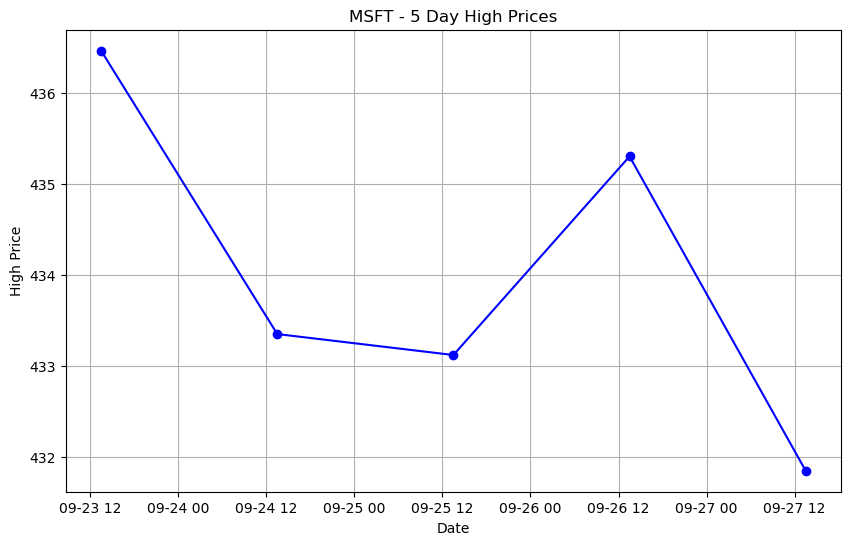

In [189]:
def get_historical_data(ticker):
    history_url = f'https://yfapi.net/v8/finance/chart/{ticker}'
    headers = {'accept': 'application/json', 'X-API-KEY': api_key}
    params = {'range': '5d', 'interval': '1d'}

    response = requests.get(history_url, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()
        timestamps = data['chart']['result'][0]['timestamp']
        prices = data['chart']['result'][0]['indicators']['quote'][0]['high']

        # Convert timestamps to human-readable dates
        dates = pd.to_datetime(timestamps, unit='s')
        return pd.DataFrame({'Date': dates, 'High Price': prices})
    else:
        print(f"Error fetching historical data for {ticker}: {response.status_code}")
        return None

historical_data = get_historical_data(ticker)
if historical_data is not None:
    plt.figure(figsize=(10, 6))
    plt.plot(historical_data['Date'], historical_data['High Price'], marker='o', linestyle='-', color='b')
    plt.title(f'{ticker} - 5 Day High Prices')
    plt.xlabel('Date')
    plt.ylabel('High Price')
    plt.grid(True)
    plt.show()
